In [ ]:
'''
MODELLING - DEEP LEARNING - 2
'''

In [1]:
import os
import joblib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, regularizers, initializers
from sklearn.preprocessing import MinMaxScaler # scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
# Model identification
MODEL_ID = '02'

# Specify the folder to export the figures
FIGURES_FOLDER = 'figures'

# Specify data and output folders
INPUT_FOLDER = 'input_files'
OUTPUT_FOLDER = 'output_files'

In [3]:
# Import x and y dataframes
df_scaled_x = joblib.load(os.path.join(INPUT_FOLDER, 'df_scaled_x.joblib'))
df_scaled_y = joblib.load(os.path.join(INPUT_FOLDER, 'df_scaled_y.joblib'))

x_scaled = df_scaled_x.values
y_scaled = df_scaled_y.values

print(f"x scaled shape: {x_scaled.shape}")
print(f"y scaled shape: {y_scaled.shape}")

x scaled shape: (721561, 5)
y scaled shape: (721561, 2)


In [4]:
# Split data into training and remaining (validation + test) sets
x_train_scaled, x_rem_scaled, y_train_scaled, y_rem_scaled = train_test_split(x_scaled, y_scaled, train_size=0.7, random_state=42)

# Split the remaining data into validation and test sets
x_val_scaled, x_test_scaled, y_val_scaled, y_test_scaled = train_test_split(x_rem_scaled, y_rem_scaled, test_size=1/3, random_state=42)

print(f"x_train shape: {x_train_scaled.shape}")
print(f"y_train shape: {y_train_scaled.shape}")
print(f"x_val shape: {x_val_scaled.shape}")
print(f"y_val shape: {y_val_scaled.shape}")
print(f"x_test shape: {x_test_scaled.shape}")
print(f"y_test shape: {y_test_scaled.shape}")

x_train shape: (505092, 5)
y_train shape: (505092, 2)
x_val shape: (144312, 5)
y_val shape: (144312, 2)
x_test shape: (72157, 5)
y_test shape: (72157, 2)


In [5]:
class ChemicalSurrogateModel:
    def __init__(self, num_features, num_outputs):
        self.num_features = num_features
        self.num_outputs = num_outputs
        
    def create_model(self):
        # Initialize with a wider network and residual connections
        inputs = layers.Input(shape=(self.num_features,))
        
        # First block
        x = layers.Dense(256, 
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(inputs)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        # Residual blocks
        for units in [128, 64, 32]:
            # Store the input to this block
            block_input = x
            
            # Dense layer with smaller units
            x = layers.Dense(units,
                           kernel_initializer='he_normal',
                           kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
            x = layers.LeakyReLU(alpha=0.1)(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.1)(x)
            
            # Add skip connection if dimensions match
            if block_input.shape[-1] == units:
                x = layers.Add()([x, block_input])
            
        # Output layer
        outputs = layers.Dense(self.num_outputs,
                             kernel_initializer='he_normal',
                             kernel_regularizer=regularizers.l2(1e-4))(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def compile_and_train(self, model, x_train_scaled, y_train_scaled, 
                         x_val_scaled, y_val_scaled, batch_size=32):
        # Custom learning rate schedule
        initial_learning_rate = 0.001
        decay_steps = 1000
        decay_rate = 0.9
        learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps, decay_rate)
        
        # Optimizer with gradient clipping
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=learning_rate_schedule,
            clipnorm=1.0
        )
        
        # Compile model
        model.compile(
            optimizer=optimizer,
            loss='huber',  # More robust to outliers than MSE
            metrics=['mse', 'mae']
        )
        
        # Callbacks
        callbacks = [
            # Early stopping with longer patience
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True,
                min_delta=1e-4
            ),
            # Learning rate reduction
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-6,
                verbose=1
            ),
            # Model checkpoint - Updated extension to .keras
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.keras',  # Changed from .h5 to .keras
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]
        
        # Train with larger batch size and more epochs
        history = model.fit(
            x_train_scaled,
            y_train_scaled,
            validation_data=(x_val_scaled, y_val_scaled),
            batch_size=batch_size,
            epochs=200,
            callbacks=callbacks,
            verbose=1
        )
        
        return history

# Create the model
num_features = x_train_scaled.shape[1]  # Number of input features
num_outputs = y_train_scaled.shape[1]   # Number of output labels

surrogate = ChemicalSurrogateModel(num_features=num_features, 
                                  num_outputs=num_outputs)
model = surrogate.create_model()

# Display model summary
model.summary()


c:\Users\davib\Downloads\EQE778_Trabalho_Individual\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,754 (182.63 KB)

 Trainable params: 45,794 (178.88 KB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Train the model
history = surrogate.compile_and_train(model, 
                                    x_train_scaled, 
                                    y_train_scaled, 
                                    x_val_scaled, 
                                    y_val_scaled,
                                    batch_size=32)



Epoch 1/200
15769/15785 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5243 - mae: 0.8684 - mse: 0.9797
Epoch 1: val_loss improved from inf to 0.42066, saving model to best_model.keras
15785/15785 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 0.5243 - mae: 0.8684 - mse: 0.9797 - val_loss: 0.4207 - val_mae: 0.8123 - val_mse: 0.8855 - learning_rate: 1.8955e-04
Epoch 2/200
15784/15785 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4279 - mae: 0.8254 - mse: 0.9018
Epoch 2: val_loss improved from 0.42066 to 0.40053, saving model to best_model.keras
15785/15785 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.4279 - mae: 0.8254 - mse: 0.9018 - val_loss: 0.4005 - val_mae: 0.7848 - val_mse: 0.8518 - learning_rate: 3.5928e-05
Epoch 3/200
15785/15785 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4180 - mae: 0.8110 - mse: 0.8886
Epoch 3: val_loss improved from 0.40053 to 0.39744, saving model to best_model.keras
15785/15785 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 0.4180 - mae: 0.8110 - mse: 0.8886 - val_loss: 0.39

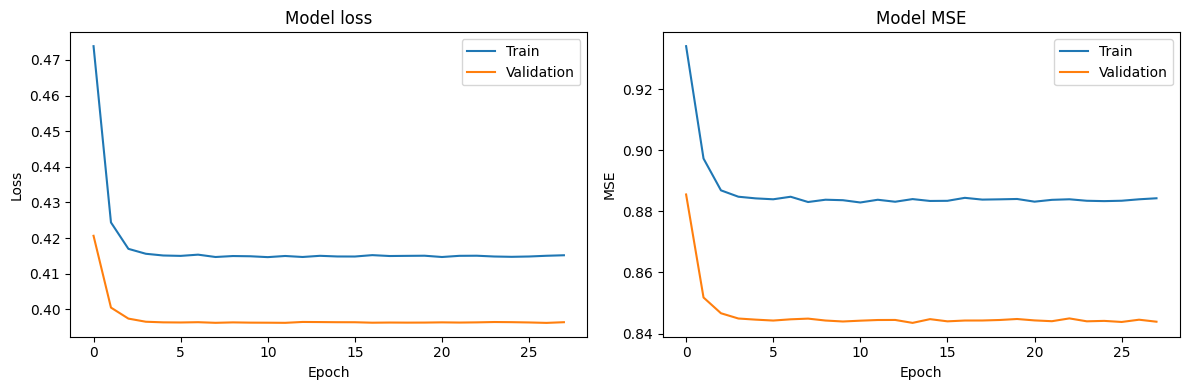

In [7]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MSE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


In [8]:

# Evaluate model on test data
test_loss, test_mse, test_mae = model.evaluate(x_test_scaled, y_test_scaled, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")



Test Loss: 0.3966
Test MSE: 0.8455
Test MAE: 0.7786


2255/2255 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step


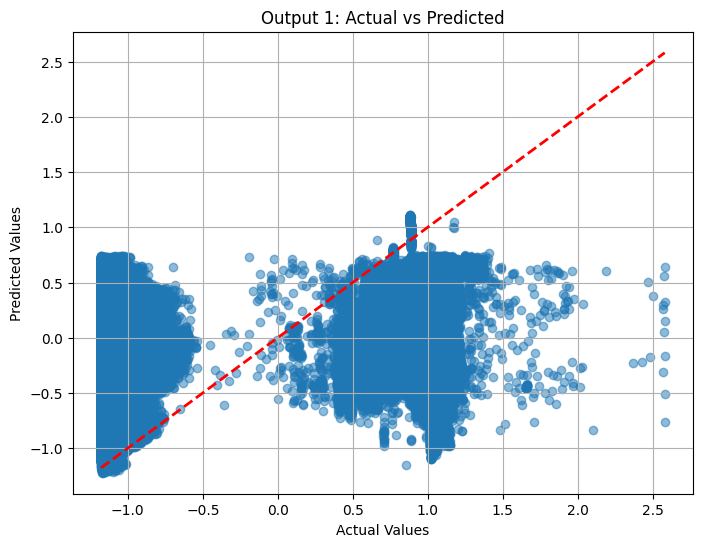

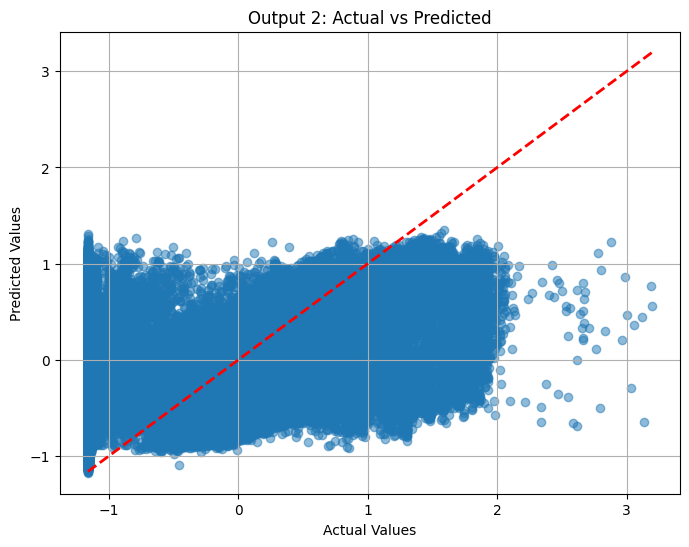

In [9]:

# Make predictions
predictions = model.predict(x_test_scaled)

# Plot actual vs predicted values for each output
for i in range(num_outputs):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_scaled[:, i], predictions[:, i], alpha=0.5)
    plt.plot([y_test_scaled[:, i].min(), y_test_scaled[:, i].max()], 
             [y_test_scaled[:, i].min(), y_test_scaled[:, i].max()], 
             'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Output {i+1}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

# Save the model - Updated extension to .keras
model.save('chemical_surrogate_model.keras')  # Changed from .h5 to .keras